**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/binary-classification).**

---


# Introduction #

In this exercise, you'll build a model to predict hotel cancellations with a binary classifier.

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex6 import *

/tmp/ipykernel_19/3338970720.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


First, load the *Hotel Cancellations* dataset.

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('../input/dl-course-data/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [3]:
hotel

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


# 1) Define Model #

The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/V04o59Z.png" width="400" alt="Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.">
<figcaption style="textalign: center; font-style: italic"><center>Diagram of a binary classifier.</center></figcaption>
</figure>


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

# Check your answer
q_1.check()

2024-02-10 13:37:05.540002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 13:37:05.540133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 13:37:05.675323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

# 2) Add Optimizer, Loss, and Metric #

Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [5]:
# YOUR CODE HERE

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [6]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

Finally, run this cell to train the model and view the learning curves. It may run for around 60 to 70 epochs, which could take a minute or two.

Epoch 1/200
175/175 [==============================] - 5s 15ms/step - loss: 0.4886 - binary_accuracy: 0.7668 - val_loss: 0.4321 - val_binary_accuracy: 0.8079
Epoch 2/200
175/175 [==============================] - 3s 14ms/step - loss: 0.4261 - binary_accuracy: 0.7994 - val_loss: 0.3996 - val_binary_accuracy: 0.8145
Epoch 3/200
175/175 [==============================] - 2s 13ms/step - loss: 0.4114 - binary_accuracy: 0.8073 - val_loss: 0.3908 - val_binary_accuracy: 0.8200
Epoch 4/200
175/175 [==============================] - 2s 13ms/step - loss: 0.4043 - binary_accuracy: 0.8106 - val_loss: 0.3861 - val_binary_accuracy: 0.8235
Epoch 5/200
175/175 [==============================] - 2s 13ms/step - loss: 0.4003 - binary_accuracy: 0.8124 - val_loss: 0.3828 - val_binary_accuracy: 0.8243
Epoch 6/200
175/175 [==============================] - 2s 13ms/step - loss: 0.3962 - binary_accuracy: 0.8158 - val_loss: 0.3791 - val_binary_accuracy: 0.8250
Epoch 7/200
175/175 [==============================]

<Axes: title={'center': 'Accuracy'}>

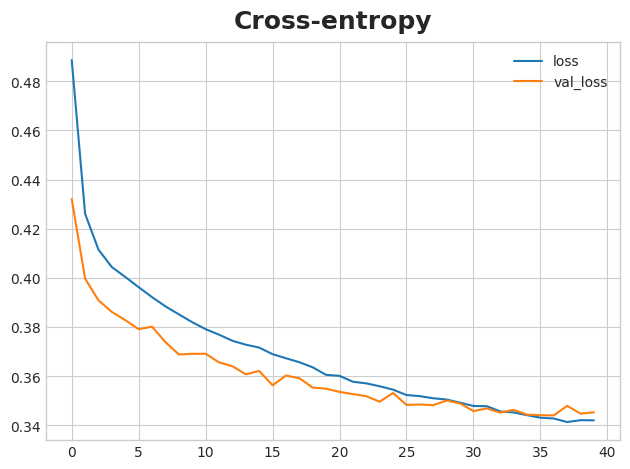

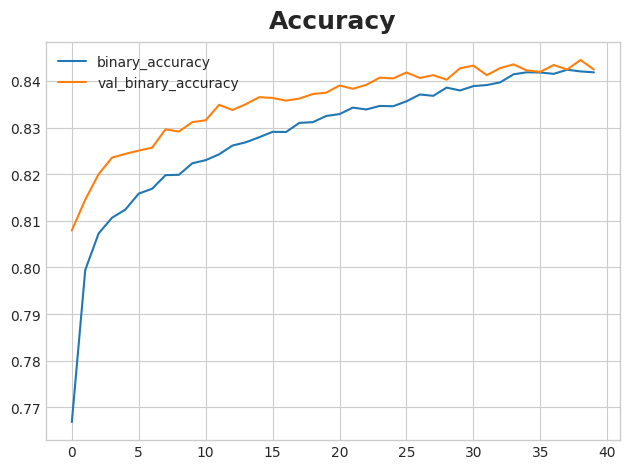

In [7]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

# 3) Train and Evaluate #


What do you think about the learning curves? Does it look like the model underfit or overfit? Was the cross-entropy loss a good stand-in for accuracy?

In [8]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Though we can see the training loss continuing to fall, the early stopping callback prevented any overfitting. Moreover, the accuracy rose at the same rate as the cross-entropy fell, so it appears that minimizing cross-entropy was a good stand-in. All in all, it looks like this training was a success!

In [9]:
# Use the trained model to predict on validation data


model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

y_pred_prob = model.predict(X_valid)


# Convert predicted probabilities to binary values
y_pred = (y_pred_prob > 0.5).astype(int)

# Create a DataFrame with validation data and predicted values
df_predicted = pd.DataFrame({
    'Actual_is_cancelled': y_valid,
    'Predicted_is_cancelled': y_pred.flatten()
})

# Display the new DataFrame
df_predicted

Epoch 1/200
175/175 [==============================] - 2s 13ms/step - loss: 0.3427 - binary_accuracy: 0.8397 - val_loss: 0.3435 - val_binary_accuracy: 0.8429
Epoch 2/200
175/175 [==============================] - 2s 13ms/step - loss: 0.3432 - binary_accuracy: 0.8411 - val_loss: 0.3434 - val_binary_accuracy: 0.8426
Epoch 3/200
175/175 [==============================] - 3s 14ms/step - loss: 0.3412 - binary_accuracy: 0.8435 - val_loss: 0.3433 - val_binary_accuracy: 0.8434
Epoch 4/200
175/175 [==============================] - 2s 13ms/step - loss: 0.3404 - binary_accuracy: 0.8433 - val_loss: 0.3425 - val_binary_accuracy: 0.8446
Epoch 5/200
175/175 [==============================] - 2s 13ms/step - loss: 0.3389 - binary_accuracy: 0.8438 - val_loss: 0.3428 - val_binary_accuracy: 0.8436
Epoch 6/200
933/933 [==============================] - 2s 2ms/step


,Actual_is_cancelled,Predicted_is_cancelled
90702,0,0
101333,0,0
107377,0,0
38088,0,0
27590,0,0
...,...,...
89980,0,0
33841,0,0
115765,0,0
63545,1,0


In [10]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8428705440900562


# Conclusion #

Congratulations! You've completed Kaggle's *Introduction to Deep Learning* course!

With your new skills you're ready to take on more advanced applications like computer vision and sentiment classification. What would you like to do next?

Why not try one of our *Getting Started* competitions?

- Classify images with TPUs in [**Petals to the Metal**](https://www.kaggle.com/c/tpu-getting-started)
- Create art with GANs in [**I'm Something of a Painter Myself**](https://www.kaggle.com/c/gan-getting-started)
- Classify Tweets in [**Real or Not? NLP with Disaster Tweets**](https://www.kaggle.com/c/nlp-getting-started)
- Detect contradiction and entailment in [**Contradictory, My Dear Watson**](https://www.kaggle.com/c/contradictory-my-dear-watson)

Until next time, Kagglers!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*